In [15]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


✅ Мусорных папок нет.
🚀 Используем устройство: cuda
⏳ Загрузка данных...
✅ Загружено классов: 15
Примеры: ['abies_concolor', 'abies_nordmanniana', 'acer_campestre', 'acer_ginnala', 'acer_griseum']
🛠 Создание архитектуры модели...

⚠️ Сохраненной модели нет. Начинаем обучение...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/10 | Train Acc: 0.1942 | Val Acc: 0.3097
Эпоха 2/10 | Train Acc: 0.4286 | Val Acc: 0.6106
Эпоха 3/10 | Train Acc: 0.6853 | Val Acc: 0.7434
Эпоха 4/10 | Train Acc: 0.7455 | Val Acc: 0.7699
Эпоха 5/10 | Train Acc: 0.8259 | Val Acc: 0.8053
Эпоха 6/10 | Train Acc: 0.8750 | Val Acc: 0.9027
Эпоха 7/10 | Train Acc: 0.8996 | Val Acc: 0.9204
Эпоха 8/10 | Train Acc: 0.9062 | Val Acc: 0.9027
Эпоха 9/10 | Train Acc: 0.9330 | Val Acc: 0.9292
Эпоха 10/10 | Train Acc: 0.9420 | Val Acc: 0.9469

💾 Сохраняем обученную модель в 'plant_classifier_resnet18.pth'...
✅ Сохранено!


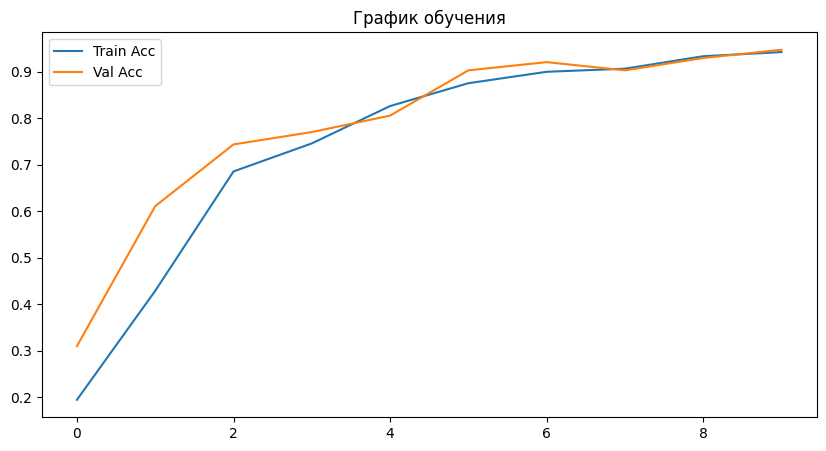


📊 Проверка качества модели...

=== Classification Report ===
                     precision    recall  f1-score   support

     abies_concolor       0.75      1.00      0.86         6
 abies_nordmanniana       1.00      0.90      0.95        10
     acer_campestre       0.80      0.67      0.73         6
       acer_ginnala       0.83      1.00      0.91         5
       acer_griseum       1.00      1.00      1.00         6
       acer_negundo       0.80      1.00      0.89         4
      acer_palmatum       1.00      0.91      0.95        23
 acer_pensylvanicum       1.00      1.00      1.00         8
   acer_platanoides       0.88      1.00      0.93         7
acer_pseudoplatanus       1.00      0.60      0.75         5
        acer_rubrum       1.00      1.00      1.00         6
   acer_saccharinum       0.91      1.00      0.95        10
     acer_saccharum       1.00      1.00      1.00         6
     aesculus_flava       1.00      0.67      0.80         3
    aesculus_glabra   

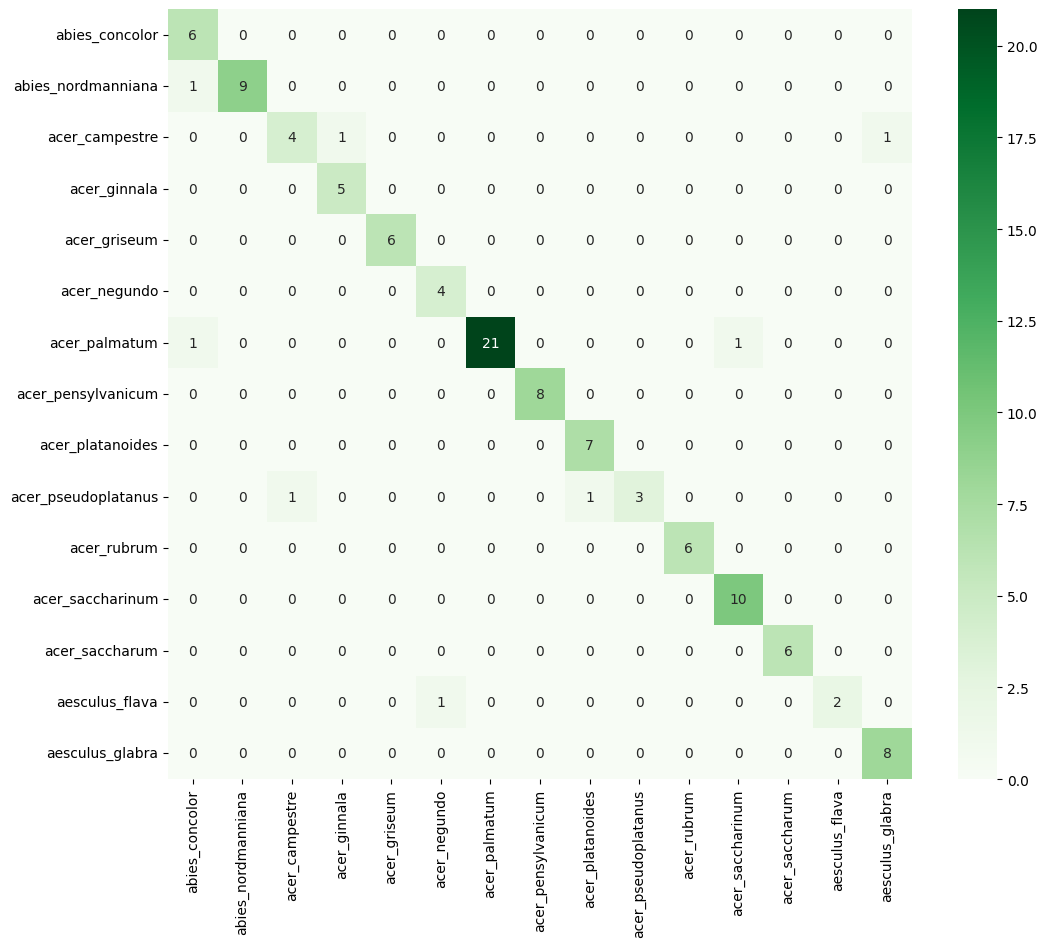

In [21]:
import os
import torch
import shutil
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. НАСТРОЙКИ
# ==========================================
DATA_DIR = os.path.join(os.getcwd(),'data')
BATCH_SIZE = 32
EPOCHS = 10  # Количество эпох (проходов по данным)
checkpoint_folder = os.path.join(DATA_DIR, '.ipynb_checkpoints')
if os.path.exists(checkpoint_folder):
    print(f"🧹 Удаляю мусорную папку: {checkpoint_folder}")
    shutil.rmtree(checkpoint_folder)
else:
    print("✅ Мусорных папок нет.")
# Проверка GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Используем устройство: {device}")


# ==========================================
# 2. АУГМЕНТАЦИЯ И ЗАГРУЗКА
# ==========================================
# Для тренировки добавляем искажения (чтобы модель не заучивала)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),    # Отражение по горизонтали
    transforms.RandomRotation(30),        # Поворот на 30 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Игра со светом
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Для валидации только размер и нормализация
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("⏳ Загрузка данных...")
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes
print(f"✅ Загружено классов: {len(class_names)}")
print(f"Примеры: {class_names[:5]}")

# Разбиваем на Обучение (80%) и Тест (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = random_split(full_dataset, [train_size, val_size])

# Создаем загрузчики (Loaders)
dataloaders = {
    'train': DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
}

# ==========================================
# 3. СОЗДАНИЕ И ЗАГРУЗКА МОДЕЛИ
# ==========================================
MODEL_SAVE_PATH = 'plant_classifier_resnet18.pth' # Имя файла для сохранения

print("🛠 Создание архитектуры модели...")
model = models.resnet18(pretrained=True)

# Замораживаем базовые слои
for param in model.parameters():
    param.requires_grad = False

# Меняем последний слой под количество наших классов
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# ==========================================
# 4. ЛОГИКА: ОБУЧАТЬ ИЛИ ЗАГРУЖАТЬ?
# ==========================================
history_train, history_val = [], [] # Пустые списки для графиков (если не будем обучать)

if os.path.exists(MODEL_SAVE_PATH):
    print(f"\n💾 Найдена сохраненная модель '{MODEL_SAVE_PATH}'!")
    print("📥 Загружаю веса...")

    # Загружаем веса в модель (map_location нужен, если сохраняли на GPU, а грузим на CPU)
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
    print("✅ Модель готова к работе без обучения.")

else:
    print(f"\n⚠️ Сохраненной модели нет. Начинаем обучение...")

    # --- ФУНКЦИЯ ОБУЧЕНИЯ ---
    def train_model(num_epochs=5):
        train_acc_hist = []
        val_acc_hist = []

        for epoch in range(num_epochs):
            model.train()
            correct = 0
            total = 0

            # Train
            for inputs, labels in dataloaders['train']:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_acc = running_corrects = correct / total
            train_acc_hist.append(epoch_acc)

            # Validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in dataloaders['val']:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            val_acc = correct / total
            val_acc_hist.append(val_acc)

            print(f"Эпоха {epoch+1}/{EPOCHS} | Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")

        return train_acc_hist, val_acc_hist

    # Запускаем обучение
    history_train, history_val = train_model(num_epochs=EPOCHS)

    # --- СОХРАНЕНИЕ ---
    print(f"\n💾 Сохраняем обученную модель в '{MODEL_SAVE_PATH}'...")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("✅ Сохранено!")

# ==========================================
# 5. ОТЧЕТ (Работает в обоих случаях)
# ==========================================
# Строим графики только если было обучение
if history_train:
    plt.figure(figsize=(10, 5))
    plt.plot(history_train, label='Train Acc')
    plt.plot(history_val, label='Val Acc')
    plt.legend()
    plt.title('График обучения')
    plt.show()
else:
    print("\nℹ️ График обучения пропущен, так как модель была загружена из файла.")

# Оценка на валидации (прогоняем данные через модель - загруженную или только что обученную)
print("\n📊 Проверка качества модели...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.show()